Note: this notebook should run in a Hail VM environment.

# PCA of AoU-LR participants vs all AoU participants

In [6]:
# standard imports
import os
import sys
import pandas as pd
import re

import math
import datetime
from dateutil import parser
from time import sleep
from typing import List
import pprint

from google.cloud import storage
my_storage_client = storage.Client()

from tqdm.notebook import tqdm
from tqdm import tqdm

In [7]:
import firecloud.api as fapi

In [8]:
import numpy as np

In [9]:
import hail as hl
from hail.plot import show
from pprint import pprint

In [10]:
import matplotlib.pyplot as plt

In [11]:
import random

In [12]:
def load_table(namespace, workspace, root_entity_type):
    ent = fapi.get_entities(namespace, workspace, root_entity_type).json()
    tbl = pd.DataFrame(list(map(lambda e: e['attributes'], ent)))
    tbl[f"entity:{root_entity_type}_id"] = list(map(lambda f: f['name'], ent))

    return tbl

In [13]:
current_account = fapi.whoami()

In [14]:
current_account

'pet-2657124278799dbb18d95@terra-7a376e4e.iam.gserviceaccount.com'

In [15]:
bucket = os.environ['WORKSPACE_BUCKET']       # gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34
workspace = os.environ['WORKSPACE_NAME']      # AoU_DRC_WGS_LongReads_PacBio
namespace = os.environ['WORKSPACE_NAMESPACE'] # allofus-drc-wgs-lr-prod

In [17]:
tbl = load_table(namespace, workspace, 'ha-sample-grch38_set')

In [18]:
tbl.head(4)

,joint_gvcf_tbi,joint_gvcf,joint_mt,ha-sample-grch38s,gcnv_genotyped_intervals_vcfs,gcnv_cohort_segment_vcf_summary_bed,gcnv_preprocessed_intervals,phased_bcf,gcnv_read_counts_entity_ids,sniffles2_std_vcf,...,gcnv_model_qc_string,shapeit4_multichr_scaffold,sniffles2_std_tbi,gcnv_sample_qc_status_files,gcnv_denoised_copy_ratios,viz_path,hificnv_cohort_summary_bed,gcnv_output_summary,flare,entity:ha-sample-grch38_set_id
0,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,"{'itemsType': 'EntityReference', 'items': [{'e...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cohort_for_GLNexus_alpha1_704
1,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,"{'itemsType': 'EntityReference', 'items': [{'e...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cohort_for_GLNexus_2023Q1_1040
2,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,"{'itemsType': 'EntityReference', 'items': [{'e...","{'itemsType': 'AttributeValue', 'items': ['gs:...",gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,"{'itemsType': 'AttributeValue', 'items': ['100...",gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,...,PASS,"{'itemsType': 'AttributeValue', 'items': ['gs:...",gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,"{'itemsType': 'AttributeValue', 'items': ['gs:...","{'itemsType': 'AttributeValue', 'items': ['gs:...",NaN,NaN,NaN,NaN,cohort_for_GLNexus_2023Q1_1027
3,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,"{'itemsType': 'EntityReference', 'items': [{'e...",NaN,NaN,NaN,NaN,NaN,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,...,NaN,NaN,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,NaN,NaN,gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1b...,NaN,NaN,NaN,cohort_3sample_test


In [19]:
joint_mt_path = list(tbl[tbl['entity:ha-sample-grch38_set_id'] == 'cohort_for_GLNexus_2023Q1_1027']['joint_mt'])[0]

In [20]:
joint_mt_path

'gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/cohort_for_GLNexus_2023Q1_1027/cohort_for_GLNexus_2023Q1_1027.mt'

In [21]:
!gsutil du -hcs {joint_mt_path}

^C
Caught CTRL-C (signal 2) - exiting


In [22]:
!gsutil ls -lh {joint_mt_path}

      12 B  2023-11-09T00:42:11Z  gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/cohort_for_GLNexus_2023Q1_1027/cohort_for_GLNexus_2023Q1_1027.mt/.README.txt.crc
       8 B  2023-11-09T00:42:11Z  gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/cohort_for_GLNexus_2023Q1_1027/cohort_for_GLNexus_2023Q1_1027.mt/._SUCCESS.crc
      24 B  2023-11-09T00:42:13Z  gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/cohort_for_GLNexus_2023Q1_1027/cohort_for_GLNexus_2023Q1_1027.mt/.metadata.json.gz.crc
     148 B  2023-11-09T00:42:09Z  gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/cohort_for_GLNexus_2023Q1_1027/cohort_for_GLNexus_2023Q1_1027.mt/README.txt
       0 B  2023-11-09T00:42:13Z  gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/cohort_for_GLNexus_2023Q1_1027/cohort_for_GLNexus_2023Q1_1027.mt/_SUCCESS
   1.8 KiB  2023-11-09T

In [23]:
hl.init(default_reference='GRCh38')

/opt/conda/lib/python3.10/site-packages/hailtop/aiocloud/aiogoogle/user_config.py:44: UserWarning:

Reading spark-defaults.conf to determine GCS requester pays configuration. This is deprecated. Please use `hailctl config set gcs_requester_pays/project` and `hailctl config set gcs_requester_pays/buckets`.

SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.
SLF4J: Class path contains SLF4J bindings targeting slf4j-api versions 1.7.x or earlier.
SLF4J: Ignoring binding found at [jar:file:/usr/lib/spark/jars/log4j-slf4j-impl-2.18.0.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See https://www.slf4j.org/codes.html#ignoredBindings for an explanation.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://saturn-74c48f39-a

In [24]:
joint_mt = hl.read_matrix_table(joint_mt_path)

In [25]:
print('Samples: %d  Variants: %d' % (joint_mt.count_cols(), joint_mt.count_rows()))

Samples: 1027  Variants: 65707900


In [26]:
hl.summarize_variants(joint_mt)

Number of alleles,Count
2,62722111
3,1773757
4,448876
5,233566
6,138349
7,89729
8,62882
9,45636
10,34432
11,26722


In [21]:
# run sample QC and save into matrix table
joint_mt = hl.sample_qc(joint_mt)

In [22]:
# run variant QC and save into matrix table
joint_mt = hl.variant_qc(joint_mt)

In [23]:
test_intervals = [
    'chr1',  'chr2',  'chr3',  'chr4',  'chr5',  'chr6',
    'chr7',  'chr8',  'chr9',  'chr10', 'chr11', 'chr12',
    'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18',
    'chr19', 'chr20', 'chr21', 'chr22'
] 

In [24]:
joint_mt = hl.filter_intervals(joint_mt, [hl.parse_locus_interval(x,) for x in test_intervals])
print('Samples: %d  Variants: %d' % (joint_mt.count_cols(), joint_mt.count_rows()))

Samples: 1027  Variants: 62965357


In [25]:
# filter for biallelic SNVs that are >95% call rate, >1% frequency, and remove sites far from HWE

In [26]:
joint_mt = joint_mt.filter_rows(hl.len(joint_mt.alleles) == 2)
print('Samples: %d  Variants: %d' % (joint_mt.count_cols(), joint_mt.count_rows()))

Samples: 1027  Variants: 60113056


In [27]:
joint_mt = joint_mt.filter_rows(hl.is_snp(joint_mt.alleles[0], joint_mt.alleles[1]))
print('Samples: %d  Variants: %d' % (joint_mt.count_cols(), joint_mt.count_rows()))

Samples: 1027  Variants: 54667267


In [28]:
joint_mt = joint_mt.filter_rows(joint_mt.variant_qc.call_rate > 0.95)
print('Samples: %d  Variants: %d' % (joint_mt.count_cols(), joint_mt.count_rows()))

Samples: 1027  Variants: 50478223


In [29]:
joint_mt = joint_mt.filter_rows(joint_mt.variant_qc.AF[1] > 0.01)
print('Samples: %d  Variants: %d' % (joint_mt.count_cols(), joint_mt.count_rows()))

Samples: 1027  Variants: 13328043


In [30]:
joint_mt = joint_mt.filter_rows(joint_mt.variant_qc.p_value_hwe > 0.005)
print('Samples: %d  Variants: %d' % (joint_mt.count_cols(), joint_mt.count_rows()))

Samples: 1027  Variants: 11377142


In [31]:
pruned_variant_table = hl.ld_prune(joint_mt.GT, r2=0.1, bp_window_size=500000)
joint_mt = joint_mt.filter_rows(hl.is_defined(pruned_variant_table[joint_mt.row_key]))

2023-03-28 01:48:33.573 Hail: INFO: ld_prune: running local pruning stage with max queue size of 218596 variants
2023-03-28 01:49:50.737 Hail: INFO: wrote table with 841813 rows in 431 partitions to /tmp/persist_tableRii5cN8gCn
    Total size: 25.85 MiB
    * Rows: 25.85 MiB
    * Globals: 11.00 B
    * Smallest partition: 179 rows (6.13 KiB)
    * Largest partition:  3588 rows (112.42 KiB)
2023-03-28 01:49:53.267 Hail: INFO: wrote table with 841813 rows in 431 partitions to /tmp/I0XafBFfiGY899u8raQgF3
2023-03-28 01:52:42.981 Hail: INFO: Wrote all 206 blocks of 841813 x 1027 matrix with block size 4096.
2023-03-28 01:55:28.706 Hail: INFO: wrote table with 15019 rows in 411 partitions to /tmp/EvhxU59do2nb30AlIdaT9b
    Total size: 11.97 MiB
    * Rows: 313.47 KiB
    * Globals: 11.66 MiB
    * Smallest partition: 0 rows (21.00 B)
    * Largest partition:  190 rows (3.47 KiB)
2023-03-28 01:55:34.545 Hail: INFO: wrote table with 831549 rows in 431 partitions to /tmp/persist_tablehbPE92ggW

In [32]:
print('Samples: %d  Variants: %d' % (joint_mt.count_cols(), joint_mt.count_rows()))

Samples: 1027  Variants: 831549


In [33]:
hl.summarize_variants(joint_mt)

Number of alleles,Count
2,831549
Allele type,Count
SNP,831549
Metric,Value
Transitions,576381
Transversions,255168
Ratio,2.26
Contig,Count
chr1,65808
chr2,65380


In [27]:
pruned_tbl_path = f'{os.path.dirname(joint_mt_path)}/pruned_tbl.ht'
pruned_tbl_path

'gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/cohort_for_GLNexus_2023Q1_1027/pruned_tbl.ht'

In [28]:
pruned_mt_path = f'{os.path.dirname(joint_mt_path)}/pruned.mt'
pruned_mt_path

'gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/cohort_for_GLNexus_2023Q1_1027/pruned.mt'

In [32]:
pruned_variant_table.write(pruned_tbl_path, overwrite=False)

2023-01-15 05:19:12.022 Hail: INFO: wrote table with 831549 rows in 431 partitions to gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/cohort_for_GLNexus_2023Q1_1027/pruned_tbl.ht


In [34]:
joint_mt.write(pruned_mt_path, overwrite=False)

2023-01-15 05:26:10.788 Hail: INFO: wrote matrix table with 831549 rows and 1027 columns in 431 partitions to gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/cohort_for_GLNexus_2023Q1_1027/pruned.mt


In [29]:
pruned_mt = hl.read_matrix_table(pruned_mt_path)

In [30]:
hl.summarize_variants(pruned_mt)

Number of alleles,Count
2,831549
Allele type,Count
SNP,831549
Metric,Value
Transitions,576381
Transversions,255168
Ratio,2.26
Contig,Count
chr1,65808
chr2,65380


In [38]:
eigenvalues, pcs, loadings = hl.hwe_normalized_pca(pruned_mt.GT, k=10, compute_loadings=True)

2023-03-28 01:57:57.983 Hail: INFO: hwe_normalize: found 831549 variants after filtering out monomorphic sites.
2023-03-28 01:58:01.068 Hail: INFO: pca: running PCA with 10 components.../ 431]
2023-03-28 01:59:18.463 Hail: INFO: Coerced sorted dataset=====>(430 + 1) / 431]
2023-03-28 01:59:22.120 Hail: INFO: wrote table with 831549 rows in 431 partitions to /tmp/persist_tableKtqJ95uskx
    Total size: 80.10 MiB
    * Rows: 80.02 MiB
    * Globals: 88.73 KiB
    * Smallest partition: 143 rows (14.29 KiB)
    * Largest partition:  3573 rows (351.43 KiB)


In [39]:
rel = hl.pc_relate(pruned_mt.GT,
                   0.01,
                   scores_expr=pcs[pruned_mt.col_key].scores,
                   min_kinship=0.1)

2023-03-28 01:59:34.423 Hail: INFO: Wrote all 204 blocks of 831549 x 1027 matrix with block size 4096.
2023-03-28 01:59:37.716 Hail: INFO: wrote matrix with 11 rows and 831549 columns as 204 blocks of size 4096 to /tmp/pcrelate-write-read-YQOjVU2FPljxv9EfCB2SiN.bm
2023-03-28 01:59:41.688 Hail: INFO: wrote matrix with 831549 rows and 1027 columns as 204 blocks of size 4096 to /tmp/pcrelate-write-read-Q1IhDUGO5dSn3puutkVNj8.bm
2023-03-28 01:59:45.686 Hail: INFO: wrote matrix with 831549 rows and 1027 columns as 204 blocks of size 4096 to /tmp/pcrelate-write-read-1aFtDkVbyBEeQleEYXrDCY.bm
ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.7/site-packages/py4j/java_gateway.py", line 1217, in send_command
    answer = smart_decode(self.stream.readline()[

KeyboardInterrupt: 

In [24]:
related_samples_to_remove = hl.maximal_independent_set(rel.i, rel.j, keep=False)

2023-01-15 17:24:01.654 Hail: INFO: wrote table with 0 rows in 0 partitions to /tmp/goC5XXwBWt4nCoqc80u1T9


In [25]:
related_samples_to_remove.count()

0

In [26]:
related_samples_path = f'{os.path.dirname(joint_mt_path)}/related_samples_to_remove.ht'
related_samples_path

related_samples_to_remove.write(related_samples_path)

2023-01-15 17:25:04.254 Hail: INFO: wrote table with 0 rows in 0 partitions to gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/cohort_for_GLNexus_2023Q1_1027/related_samples_to_remove.ht


In [27]:
rel.show()

,,,,,
i,j,,,,
s,s,kin,ibd0,ibd1,ibd2
str,str,float64,float64,float64,float64


In [40]:
pprint(eigenvalues)

[7.19926653690558,
 1.3119396734910567,
 1.2493602869847484,
 1.2337160976447195,
 1.2248507253683218,
 1.2206022629035658,
 1.2173678904103196,
 1.215111241399811,
 1.2065672887990901,
 1.2039300706917686]


In [29]:
pcs.show(1027, width=100)

2023-01-24 16:06:02.193 Hail: INFO: Coerced sorted dataset


,
s,scores
str,array<float64>
"""1000151""","[3.12e-02,7.50e-03,8.95e-03,-1.27e-02,1.05e-02,-1.27e-02,2.88e-02,9.36e-03,5.19e-02,2.51e-03]"
"""1000513""","[-3.69e-02,8.34e-03,2.24e-02,1.38e-02,-3.68e-04,3.68e-02,1.15e-02,-2.01e-02,4.48e-02,1.07e-02]"
"""1000920""","[3.16e-02,2.37e-02,-1.44e-02,-3.40e-02,9.23e-03,-7.57e-02,-5.30e-02,-6.76e-02,3.70e-02,2.15e-02]"
"""1001399""","[3.40e-02,6.03e-03,-4.08e-02,-2.39e-02,1.52e-02,-5.71e-03,6.35e-02,-1.54e-02,-4.12e-03,-4.25e-02]"
"""1001980""","[-1.74e-01,-6.73e-03,4.48e-02,-3.01e-02,-2.15e-02,-2.76e-02,4.68e-02,-5.77e-02,-1.22e-02,-4.79e-03]"
"""1002322""","[2.29e-02,-6.23e-04,-2.91e-02,2.99e-02,2.42e-02,-2.61e-02,1.34e-02,5.41e-02,-2.64e-02,-4.41e-02]"
"""1002826""","[2.62e-02,-9.48e-03,3.58e-03,3.92e-02,-4.28e-02,-3.15e-03,-8.05e-03,-1.12e-02,-2.50e-02,-4.69e-02]"
"""1004266""","[5.55e-02,1.97e-02,-6.60e-03,-1.32e-02,-3.59e-02,-7.31e-03,-4.35e-02,2.50e-02,2.77e-02,-2.02e-02]"


In [30]:
pruned_mt = pruned_mt.annotate_cols(scores = pcs[pruned_mt.s].scores)

In [32]:
pruned_mt.count()

(831549, 1027)

In [31]:
hl.plot.output_notebook()

p = hl.plot.scatter(pruned_mt.scores[0],
                    pruned_mt.scores[1],
                    hover_fields={'sample': pruned_mt.s},
                    title='PCA', xlabel='PC1', ylabel='PC2', collect_all=True)
show(p)

Loading BokehJS ...

In [16]:
!gsutil ls -lh gs://gcp-public-data--gnomad/release/3.1/pca/

  2.65 MiB  2022-01-06T18:48:15Z  gs://gcp-public-data--gnomad/release/3.1/pca/gnomad.v3.1.RF_fit.pkl
 23.52 MiB  2022-10-14T16:37:45Z  gs://gcp-public-data--gnomad/release/3.1/pca/gnomad.v3.1.pca_loadings.tsv.gz
                                 gs://gcp-public-data--gnomad/release/3.1/pca/gnomad.v3.1.pca_loadings.ht/
TOTAL: 2 objects, 27443695 bytes (26.17 MiB)


In [17]:
path_to_gnomad_loadings = 'gs://gcp-public-data--gnomad/release/3.1/pca/gnomad.v3.1.pca_loadings.ht'
path_to_gnomad_rf = 'gs://gcp-public-data--gnomad/release/3.1/pca/gnomad.v3.1.RF_fit.pkl'

In [18]:
import pickle
import hail as hl
from gnomad.sample_qc.ancestry import assign_population_pcs

In [20]:
# Load MatrixTable for projection and gnomAD loadings Hail Table
#mt_to_project = hl.read_matrix_table(path_to_matrix_table)
mt_to_project = joint_mt
loadings_ht = hl.read_table(path_to_gnomad_loadings)

In [21]:
# Project new genotypes onto loadings
ht = hl.experimental.pc_project(
    mt_to_project.GT,
    loadings_ht.loadings,
    loadings_ht.pca_af,
)

2023-01-17 18:10:26.820 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'


In [22]:
# Assign global ancestry using the gnomAD RF model and PC project scores
# Loading of the v2 RF model requires an older version of scikit-learn, this can be installed using pip install -U scikit-learn==0.21.3
with hl.hadoop_open(path_to_gnomad_rf, "rb") as f:
    fit = pickle.load(f)

# Reduce the scores to only those used in the RF model, this was 6 for v2 and 16 for v3.1
num_pcs = fit.n_features_
ht = ht.annotate(scores=ht.scores[:num_pcs])
ht, rf_model = assign_population_pcs(
    ht,
    pc_cols=ht.scores,
    fit=fit,
)

# The returned Hail Table includes the imputed population labels and RF probabilities for each gnomAD global population

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(

In [23]:
ht.show(1030)

2023-01-17 18:15:26.721 Hail: INFO: Coerced sorted dataset


,,,,,,,,,,,,
s,pca_scores,pop,prob_afr,prob_ami,prob_amr,prob_asj,prob_eas,prob_fin,prob_mid,prob_nfe,prob_oth,prob_sas
str,array<float64>,str,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
"""1000151""","[-2.67e-01,-4.87e-03,6.99e-03,2.73e-03,-3.94e-03,-5.32e-03,1.61e-03,-2.58e-03,4.98e-04,-1.43e-03,-3.40e-03,2.97e-03,7.24e-03,8.63e-03,-3.00e-03,4.94e-04]","""afr""",1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
"""1000513""","[-2.03e-01,-6.95e-03,7.99e-03,3.42e-03,-3.53e-03,5.13e-03,-1.49e-03,-6.84e-04,3.86e-03,-1.80e-03,-1.90e-03,1.03e-03,7.13e-03,-2.54e-03,-1.17e-02,-4.55e-03]","""afr""",1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
"""1000920""","[-2.45e-01,-6.42e-03,7.53e-03,4.06e-03,1.72e-03,-9.86e-04,1.52e-03,2.37e-03,1.30e-03,-5.63e-04,3.21e-03,1.04e-03,1.84e-04,1.59e-03,5.25e-03,8.82e-03]","""afr""",1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
"""1001399""","[-2.58e-01,-8.49e-03,8.94e-03,4.48e-03,1.96e-03,-4.00e-03,-3.42e-04,1.36e-03,1.24e-03,1.78e-03,8.87e-04,-1.07e-03,-8.61e-04,-1.35e-02,-6.56e-03,-1.35e-02]","""afr""",1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
"""1001980""","[-8.35e-02,1.21e-02,-3.48e-02,7.88e-03,1.78e-03,-1.77e-02,3.40e-03,1.37e-03,4.24e-03,-8.69e-03,-1.76e-02,4.93e-04,1.47e-02,-1.49e-02,-5.92e-04,-4.02e-03]","""oth""",7.10e-01,0.00e+00,2.80e-01,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e-02
"""1002322""","[-2.59e-01,-4.15e-03,1.09e-02,6.91e-03,3.44e-03,-2.55e-03,-1.70e-04,5.95e-04,-3.37e-05,2.99e-03,3.77e-03,-1.04e-03,1.66e-03,7.79e-03,-1.64e-02,-6.96e-03]","""afr""",1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
"""1002826""","[-2.36e-01,-2.41e-03,6.48e-03,2.09e-03,-7.82e-04,9.11e-04,2.04e-03,-2.11e-03,-5.90e-05,7.96e-04,8.19e-06,-3.21e-04,-7.52e-03,-3.73e-03,1.69e-02,1.41e-02]","""afr""",1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
"""1004266""","[-2.69e-01,1.25e-03,6.24e-03,7.13e-03,1.41e-03,-5.39e-03,1.11e-03,3.63e-04,-1.87e-03,-4.15e-03,-6.69e-03,2.84e-03,-4.09e-03,-2.79e-03,-8.44e-03,-9.80e-03]","""afr""",1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00


In [27]:
q = ht.collect()

In [29]:
import matplotlib.pyplot as plt

In [ ]:
samples = np.array([])
prob_afr = np.array([])
prob_ami = np.array([])
prob_amr = np.array([])
prob_asj = np.array([])
prob_eas = np.array([])
prob_fin = np.array([])
prob_mid = np.array([])
prob_nfe = np.array([])
prob_oth = np.array([])
prob_sas = np.array([])

for i in range(0, len(q)):
    samples = np.append(samples, q[i].s)
    prob_afr = np.append(prob_afr, q[i].prob_afr)
    prob_ami = np.append(prob_ami, q[i].prob_ami)
    prob_amr = np.append(prob_amr, q[i].prob_amr)
    prob_asj = np.append(prob_asj, q[i].prob_asj)
    prob_eas = np.append(prob_eas, q[i].prob_eas)
    prob_fin = np.append(prob_fin, q[i].prob_fin)
    prob_mid = np.append(prob_mid, q[i].prob_mid)
    prob_nfe = np.append(prob_nfe, q[i].prob_nfe)
    prob_oth = np.append(prob_oth, q[i].prob_oth)
    prob_sas = np.append(prob_sas, q[i].prob_sas)
    
p = prob_afr.argsort()

samples = samples[p]
prob_afr = prob_afr[p]
prob_ami = prob_ami[p]
prob_amr = prob_amr[p]
prob_asj = prob_asj[p]
prob_eas = prob_eas[p]
prob_fin = prob_fin[p]
prob_mid = prob_mid[p]
prob_nfe = prob_nfe[p]
prob_oth = prob_oth[p]
prob_sas = prob_sas[p]

In [55]:
plt.rcParams.update({'font.size': 15})


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.


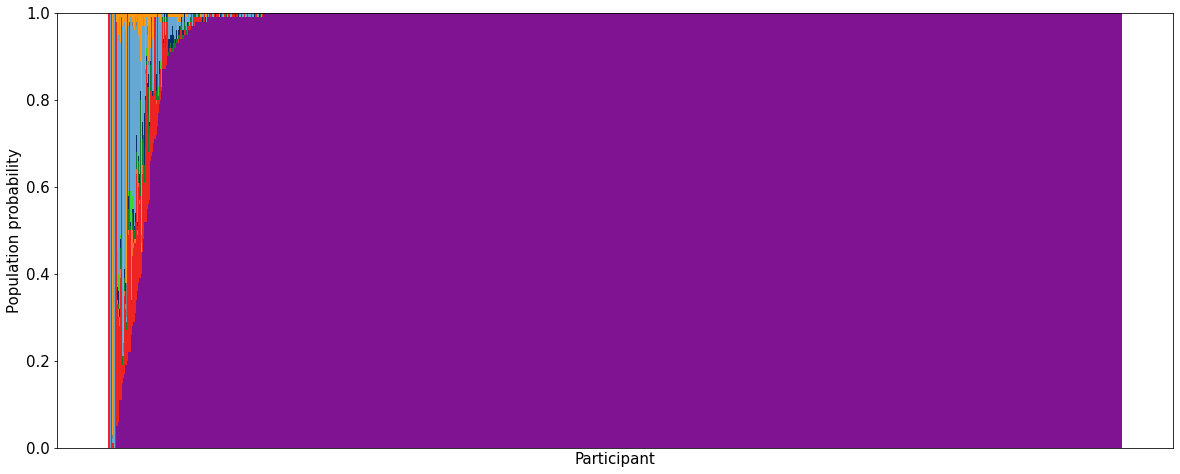

In [58]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

plt.bar(samples, prob_afr, color='#7F1391', align='edge', width=1.0)
plt.bar(samples, prob_ami, color='#FEBFCB', align='edge', width=1.0, bottom=prob_afr)
plt.bar(samples, prob_amr, color='#EE2324', align='edge', width=1.0, bottom=prob_afr + prob_ami)
plt.bar(samples, prob_asj, color='#FB683E', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr)
plt.bar(samples, prob_eas, color='#127D31', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj)
plt.bar(samples, prob_fin, color='#072f69', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj + prob_eas)
plt.bar(samples, prob_mid, color='#36D335', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj + prob_eas + prob_fin)
plt.bar(samples, prob_nfe, color='#67A8D2', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj + prob_eas + prob_fin + prob_mid)
plt.bar(samples, prob_oth, color='#7F7F7F', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj + prob_eas + prob_fin + prob_mid + prob_nfe)
plt.bar(samples, prob_sas, color='#FE9911', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj + prob_eas + prob_fin + prob_mid + prob_nfe + prob_oth)

plt.xlabel('Participant')
plt.ylabel('Population probability')

frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.


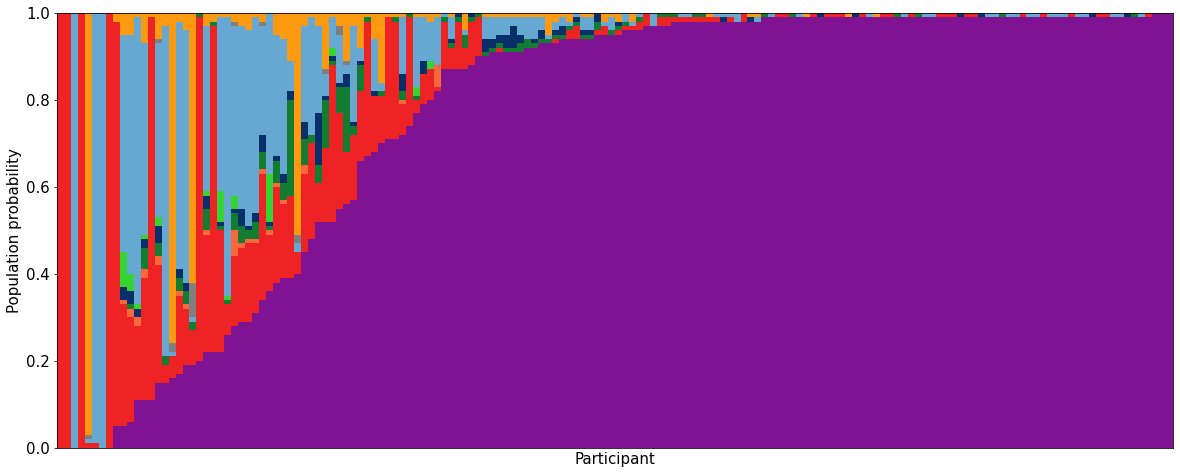

In [57]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

plt.bar(samples, prob_afr, color='#7F1391', align='edge', width=1.0)
plt.bar(samples, prob_ami, color='#FEBFCB', align='edge', width=1.0, bottom=prob_afr)
plt.bar(samples, prob_amr, color='#EE2324', align='edge', width=1.0, bottom=prob_afr + prob_ami)
plt.bar(samples, prob_asj, color='#FB683E', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr)
plt.bar(samples, prob_eas, color='#127D31', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj)
plt.bar(samples, prob_fin, color='#072f69', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj + prob_eas)
plt.bar(samples, prob_mid, color='#36D335', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj + prob_eas + prob_fin)
plt.bar(samples, prob_nfe, color='#67A8D2', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj + prob_eas + prob_fin + prob_mid)
plt.bar(samples, prob_oth, color='#7F7F7F', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj + prob_eas + prob_fin + prob_mid + prob_nfe)
plt.bar(samples, prob_sas, color='#FE9911', align='edge', width=1.0, bottom=prob_afr + prob_ami + prob_amr + prob_asj + prob_eas + prob_fin + prob_mid + prob_nfe + prob_oth)

plt.xlabel('Participant')
plt.ylabel('Population probability')
plt.xlim(0, 160)

frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])

plt.show()

In [137]:
hl.plot.output_notebook()

p = hl.plot.scatter(ht.pca_scores[0],
                    ht.pca_scores[1],
                    hover_fields={'sample': ht.s},
                    title='PCA', xlabel='PC1', ylabel='PC2', collect_all=True)
show(p)

2023-01-16 06:45:00.043 Hail: INFO: Coerced sorted dataset


### Project long read SNVs/small indels into PCA space of the 245k short read samples.

In [41]:
!gsutil ls -lh gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry

 96.71 MiB  2023-02-28T02:18:44Z  gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.tsv
  2.24 MiB  2023-02-28T02:18:47Z  gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/delta_v1_gt_no_ext_aian_gq0_prod.preds_oth.html
  2.98 MiB  2023-02-28T02:18:49Z  gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/merged_sites_only_intersection.vcf.bgz
361.94 KiB  2023-02-28T02:18:52Z  gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/merged_sites_only_intersection.vcf.bgz.tbi
                                 gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/
TOTAL: 4 objects, 107246408 bytes (102.28 MiB)


In [42]:
loadings_ht = hl.methods.read_table('gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht')


In [43]:
loadings_ht.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh38> 
    'alleles': array<str> 
    'loadings': array<float64> 
    'af': float64 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


In [44]:
testing_ht = hl.experimental.pc_project(joint_mt.GT, loadings_ht.loadings, loadings_ht.af)

2023-03-28 02:01:44.678 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'


In [45]:
!gsutil ls -lh gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/

                                 gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/ComputeReadLengths/
                                 gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/HiFiCNV/
                                 gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/JointCallGVCFs/
                                 gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/LRMergeSVVCFs/
                                 gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/LRStatisticallyPhaseVariants/
                                 gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/LRVisualizeVariants/
                                 gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/PAV/
                                 gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/PBCCSWholeGenome/
                                 gs://fc-secure-f7d80b48-be60-426f

In [46]:
testing_ht_path = 'gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/scratch/pca_project/testing.ht'

In [19]:
testing_ht.write(testing_ht_path, overwrite=False)

2023-03-06 16:07:15.752 Hail: INFO: Coerced sorted dataset>       (14 + 2) / 16]
2023-03-06 16:07:20.747 Hail: INFO: wrote table with 1027 rows in 16 partitions to gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/outputs/GRCh38/scratch/pca_project/testing.ht


In [47]:
testing_ht = hl.read_table(testing_ht_path)

In [48]:
testing_ht.count()

1027

In [49]:
testing_ht.show(5)

,
s,scores
str,array<float64>
"""1000151""","[-2.33e-01,3.36e-03,4.07e-04,8.51e-03,6.44e-03,-3.74e-03,8.83e-03,-2.40e-03,-4.01e-04,3.65e-03,-5.85e-03,6.37e-04,-4.25e-03,-5.58e-03,-8.63e-03,6.34e-04]"
"""1000513""","[-1.75e-01,1.92e-02,-2.74e-03,1.58e-02,9.46e-03,3.55e-03,1.64e-02,7.14e-03,1.44e-03,3.96e-03,8.92e-03,7.14e-04,-2.21e-04,-2.41e-03,5.45e-03,6.38e-03]"
"""1000920""","[-2.25e-01,6.76e-03,6.79e-04,8.64e-03,1.19e-02,-2.56e-03,1.02e-02,7.42e-03,7.80e-05,5.04e-03,9.26e-03,-4.28e-04,-4.01e-03,4.07e-03,-1.29e-02,7.58e-03]"
"""1001399""","[-2.32e-01,7.82e-03,-7.66e-04,9.14e-03,1.51e-02,-6.68e-03,1.26e-02,5.13e-03,1.28e-03,2.79e-03,2.46e-04,-5.94e-03,2.06e-03,-8.12e-04,9.23e-04,-5.88e-03]"
"""1001980""","[-6.48e-02,3.73e-02,2.11e-02,1.17e-02,-2.88e-04,-5.37e-03,-6.41e-03,1.02e-02,-3.63e-04,2.02e-03,-2.14e-03,-1.09e-03,1.90e-03,3.05e-03,-4.29e-03,3.68e-03]"


In [50]:
testing_ht.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    's': str 
    'scores': array<float64> 
----------------------------------------
Key: ['s']
----------------------------------------


In [51]:
!gsutil ls -lh gs://prod-drc-broad/aou-wgs-delta-aux_gq0/*/

gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/:
 96.71 MiB  2023-02-28T02:18:44Z  gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.tsv
  2.24 MiB  2023-02-28T02:18:47Z  gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/delta_v1_gt_no_ext_aian_gq0_prod.preds_oth.html
  2.98 MiB  2023-02-28T02:18:49Z  gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/merged_sites_only_intersection.vcf.bgz
361.94 KiB  2023-02-28T02:18:52Z  gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/merged_sites_only_intersection.vcf.bgz.tbi
                                 gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/delta_v1_gt_no_ext_aian_gq0_prod_loadings.ht/

gs://prod-drc-broad/aou-wgs-delta-aux_gq0/qc/:
 299.9 KiB  2023-02-28T02:18:23Z  gs://prod-drc-broad/aou-wgs-delta-aux_gq0/qc/delta_v1_gt_no_ext_aian_gq0_prod.flagged_samples.tsv
 76.46 MiB  2023-02-28T02:18:26Z  gs://prod-drc-broad/aou-wgs-delta-aux_gq0/qc/delta_v1_gt_no_ext_aian_gq0_prod.met

In [53]:
!gsutil cp gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.tsv .

Copying gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.tsv...
\ [1 files][ 96.7 MiB/ 96.7 MiB]                                                
Operation completed over 1 objects/96.7 MiB.                                     


In [54]:
ancestry_preds = pd.read_table('delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.tsv')

In [55]:
ancestry_preds['research_id'] = ancestry_preds['research_id'].astype(str)

In [56]:
ancestry_preds

,research_id,ancestry_pred,probabilities,pca_features,ancestry_pred_other
0,1000004,eur,"[0.0, 0.0, 0.01, 0.99, 0.0, 0.0]","[0.10051663592874799, 0.1360249193403286, -0.0...",eur
1,1000033,eur,"[0.0, 0.0, 0.01, 0.99, 0.0, 0.0]","[0.09828612276613305, 0.12465899985829886, -0....",eur
2,1000039,afr,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.26592708178595414, 0.004729216912298321, -...",afr
3,1000042,afr,"[0.98, 0.01, 0.0, 0.0, 0.0, 0.01]","[-0.25547433413383014, 0.005969157650966834, 0...",afr
4,1000045,eas,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.09727124534081225, -0.15845581375982454, -0...",eas
...,...,...,...,...,...
245389,9998987,sas,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.08582369643346302, 0.027805658064294463, -0...",sas
245390,9999351,afr,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.2680591746227485, 0.005229792974629954, 0....",afr
245391,9999412,eur,"[0.01, 0.14, 0.02, 0.61, 0.16, 0.06]","[0.08289853139379988, 0.11146646312869944, -0....",oth
245392,9999653,amr,"[0.25, 0.75, 0.0, 0.0, 0.0, 0.0]","[-0.09018968453748215, 0.009837692604324563, 0...",oth


In [57]:
from collections import Counter

Counter(list(ancestry_preds['ancestry_pred_other']))

Counter({'eur': 123072,
         'afr': 53944,
         'eas': 5381,
         'amr': 40838,
         'oth': 19289,
         'mid': 528,
         'sas': 2342})

In [58]:
ancestry_preds[ancestry_preds['ancestry_pred_other'] == 'afr']

,research_id,ancestry_pred,probabilities,pca_features,ancestry_pred_other
2,1000039,afr,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.26592708178595414, 0.004729216912298321, -...",afr
3,1000042,afr,"[0.98, 0.01, 0.0, 0.0, 0.0, 0.01]","[-0.25547433413383014, 0.005969157650966834, 0...",afr
16,1000151,afr,"[0.93, 0.03, 0.02, 0.01, 0.0, 0.01]","[-0.25528041742432944, 0.007663665799122799, 0...",afr
18,1000168,afr,"[0.98, 0.02, 0.0, 0.0, 0.0, 0.0]","[-0.24935624894028335, 0.01162830353016943, -0...",afr
22,1000192,afr,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.2728272010026481, 0.004116349830832951, 2....",afr
...,...,...,...,...,...
245362,9993483,afr,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.3067229448783013, -0.006554244129239928, -...",afr
245372,9996195,afr,"[0.77, 0.21, 0.01, 0.0, 0.01, 0.0]","[-0.16158374670949713, 0.03273421236808533, 0....",afr
245374,9996889,afr,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.22865277794629266, 0.01802353292514426, -0...",afr
245382,9998323,afr,"[0.97, 0.03, 0.0, 0.0, 0.0, 0.0]","[-0.19165886556312212, 0.03119798950536854, -0...",afr


In [60]:
ancestry_preds[ancestry_preds['research_id'].isin(testing_ht.s.collect())]

,research_id,ancestry_pred,probabilities,pca_features,ancestry_pred_other
16,1000151,afr,"[0.93, 0.03, 0.02, 0.01, 0.0, 0.01]","[-0.25528041742432944, 0.007663665799122799, 0...",afr
72,1000513,afr,"[0.99, 0.01, 0.0, 0.0, 0.0, 0.0]","[-0.19764709867009297, 0.024337263300147717, -...",afr
121,1000920,afr,"[0.99, 0.01, 0.0, 0.0, 0.0, 0.0]","[-0.24749929688630692, 0.009890229485607435, 0...",afr
185,1001399,afr,"[0.99, 0.01, 0.0, 0.0, 0.0, 0.0]","[-0.25960936264072526, 0.010743319987418624, 0...",afr
251,1001980,amr,"[0.28, 0.68, 0.0, 0.02, 0.01, 0.01]","[-0.07898347609679711, 0.04408461507516266, 0....",oth
...,...,...,...,...,...
239766,8838544,afr,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.3171899112067199, -0.009578375670658583, 0...",afr
242118,9322885,afr,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.2951115918396019, -4.399301252355921e-05, ...",afr
243083,9526330,afr,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.23145518517304872, 0.018379550012895717, 0...",afr
243817,9674245,afr,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.17865665720081036, 0.036235942016449155, -...",afr


In [61]:
ancestry_preds_tbl = hl.import_table(
    'gs://prod-drc-broad/aou-wgs-delta-aux_gq0/ancestry/delta_v1_gt_no_ext_aian_gq0_prod.ancestry_preds.tsv',
    types={ 'pca_features': hl.tarray(hl.tfloat64) }
)

ancestry_preds_tbl.show(20)

2023-03-28 02:04:06.080 Hail: INFO: wrote table with 245395 rows in 1 partition to /tmp/persist_table9A52naI0pq
2023-03-28 02:04:06.704 Hail: INFO: Reading table without type imputation1) / 1]
  Loading field 'research_id' as type str (not specified)
  Loading field 'ancestry_pred' as type str (not specified)
  Loading field 'probabilities' as type str (not specified)
  Loading field 'pca_features' as type array<float64> (user-supplied)
  Loading field 'ancestry_pred_other' as type str (not specified)


,,,,
research_id,ancestry_pred,probabilities,pca_features,ancestry_pred_other
str,str,str,array<float64>,str
"""1000004""","""eur""","""[0.0, 0.0, 0.01, 0.99, 0.0, 0.0]""","[1.01e-01,1.36e-01,-6.32e-03,5.22e-02,3.26e-03,1.63e-02,1.60e-02,-2.15e-03,-1.44e-03,1.01e-03,1.43e-03,-5.13e-04,5.04e-05,-6.64e-04,8.59e-04,-1.32e-03]","""eur"""
"""1000033""","""eur""","""[0.0, 0.0, 0.01, 0.99, 0.0, 0.0]""","[9.83e-02,1.25e-01,-9.63e-03,4.32e-02,3.48e-03,2.08e-02,2.26e-02,-2.58e-03,-1.35e-03,6.19e-05,-1.37e-04,4.62e-04,4.82e-04,7.05e-04,6.07e-04,8.18e-04]","""eur"""
"""1000039""","""afr""","""[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]""","[-2.66e-01,4.73e-03,-1.06e-03,1.81e-03,3.15e-02,2.32e-03,6.27e-03,1.32e-02,-1.83e-03,2.63e-03,-1.64e-03,6.89e-03,3.55e-03,2.39e-03,4.75e-03,4.30e-03]","""afr"""
"""1000042""","""afr""","""[0.98, 0.01, 0.0, 0.0, 0.0, 0.01]""","[-2.55e-01,5.97e-03,2.74e-03,8.75e-03,1.02e-02,9.69e-03,-6.93e-04,-2.68e-03,1.04e-02,6.88e-03,3.77e-03,-3.04e-03,-2.77e-03,9.05e-04,2.44e-03,5.67e-03]","""afr"""
"""1000045""","""eas""","""[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]""","[9.73e-02,-1.58e-01,-4.39e-02,3.49e-02,-3.16e-04,-4.19e-03,-3.38e-03,8.09e-04,-1.32e-04,-8.36e-04,2.06e-04,1.80e-04,9.49e-05,-5.99e-04,4.56e-04,-7.37e-04]","""eas"""
"""1000059""","""eur""","""[0.0, 0.01, 0.13, 0.86, 0.0, 0.0]""","[1.01e-01,1.29e-01,-3.49e-03,4.23e-02,1.63e-03,1.31e-02,1.42e-02,-2.32e-03,-3.60e-04,-4.94e-04,2.24e-04,-2.09e-03,8.47e-04,-3.23e-04,4.63e-04,-3.10e-04]","""eur"""
"""1000061""","""eur""","""[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]""","[1.01e-01,1.33e-01,-1.25e-02,4.67e-02,2.54e-03,1.95e-02,2.18e-02,-4.58e-03,-1.88e-03,9.15e-05,-5.87e-04,-2.96e-04,-7.70e-05,-9.73e-04,4.11e-05,-1.93e-03]","""eur"""
"""1000070""","""eur""","""[0.0, 0.0, 0.01, 0.99, 0.0, 0.0]""","[1.01e-01,1.34e-01,-1.11e-02,4.71e-02,2.32e-03,1.92e-02,2.22e-02,-3.75e-03,-2.57e-03,1.39e-06,-2.10e-04,-1.37e-03,-1.88e-04,-5.19e-04,1.80e-03,7.31e-05]","""eur"""


In [62]:
ancestry_preds_tbl.count()

245394

In [63]:
l = ancestry_preds_tbl.ancestry_pred_other.collect()

In [64]:
Counter(l)

Counter({'eur': 123072,
         'afr': 53944,
         'eas': 5381,
         'amr': 40838,
         'oth': 19289,
         'mid': 528,
         'sas': 2342})

In [65]:
color_map = {
    'afr': '#D573BE',
    'amr': '#519D3E',
    'eas': '#C53A32',
    'eur': '#3976AF',
    'mid': '#EF8536',
    'sas': '#866BE8',
    'oth': '#84584E'
}

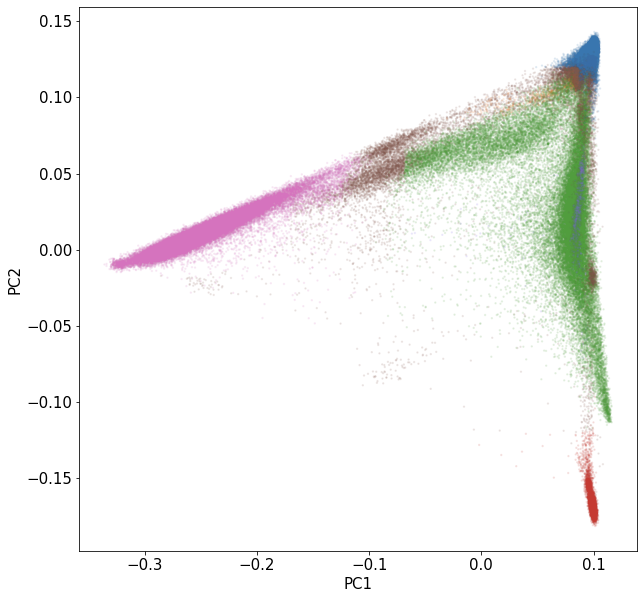

In [66]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 15})

plt.scatter(
    ancestry_preds_tbl.pca_features[0].collect(),
    ancestry_preds_tbl.pca_features[1].collect(),
    color=[f'{color_map[item]}1A' for item in l],
    s=2
)

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

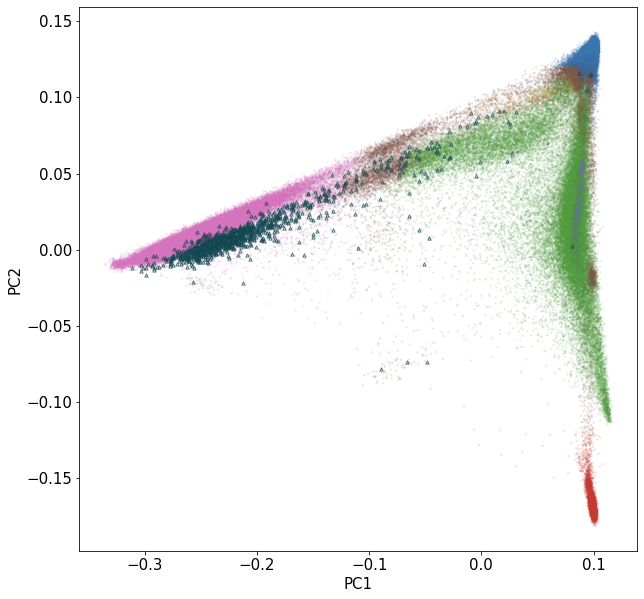

In [53]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 15})

plt.scatter(
    ancestry_preds_tbl.pca_features[0].collect(),
    ancestry_preds_tbl.pca_features[1].collect(),
    color=[f'{color_map[item]}1A' for item in l],
    s=2
)

plt.scatter(
    testing_ht.scores[0].collect(),
    testing_ht.scores[1].collect(),
    marker="^",
    edgecolor="#10454FBB",
    color="#ffffff11",
    s=10
)

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

In [69]:
q = ancestry_preds[ancestry_preds['research_id'].isin(testing_ht.s.collect())]

In [57]:
Counter(q['ancestry_pred_other'])

Counter({'afr': 936, 'oth': 79, 'amr': 7, 'eur': 3, 'sas': 2})

In [60]:
79 + 7 + 3 + 2

91

In [70]:
a1 = [[float(f) for f in re.split(",", re.sub(r"[\[\]]", "", item))] for item in list(q.pca_features)]

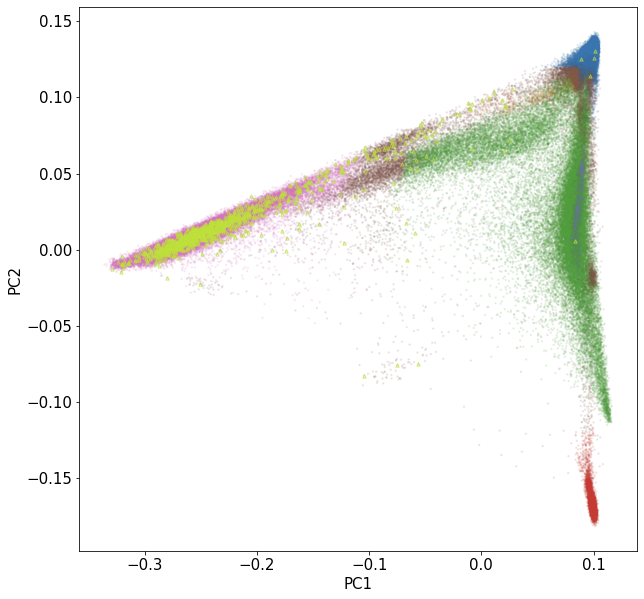

In [63]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 15})

plt.scatter(
    ancestry_preds_tbl.pca_features[0].collect(),
    ancestry_preds_tbl.pca_features[1].collect(),
    color=[f'{color_map[item]}1A' for item in l],
    s=2
)

plt.scatter(
    [item[0] for item in a1],
    [item[1] for item in a1],
    marker="^",
    edgecolor="#BDE038BB",
    color="#ffffff11",
    s=10
)

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

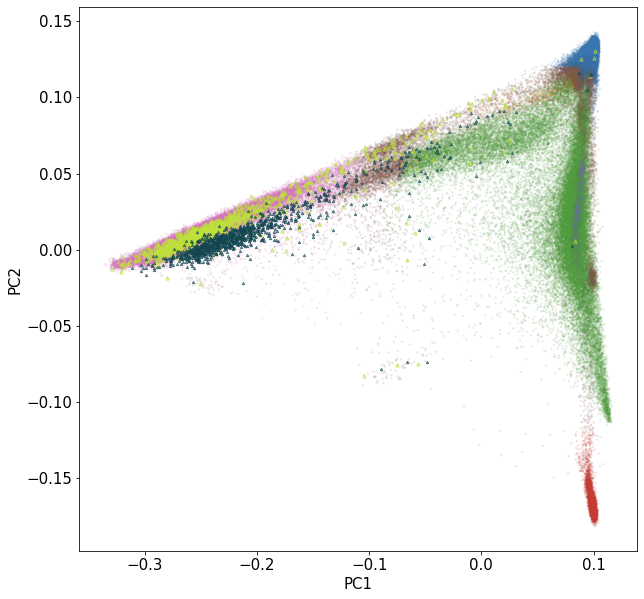

In [65]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 15})

plt.scatter(
    ancestry_preds_tbl.pca_features[0].collect(),
    ancestry_preds_tbl.pca_features[1].collect(),
    color=[f'{color_map[item]}1A' for item in l],
    s=2
)

plt.scatter(
    [item[0] for item in a1],
    [item[1] for item in a1],
    marker="^",
    edgecolor="#BDE038BB",
    color="#ffffff11",
    s=10
)

plt.scatter(
    testing_ht.scores[0].collect(),
    testing_ht.scores[1].collect(),
    marker="^",
    edgecolor="#10454FBB",
    color="#ffffff11",
    s=5
)

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

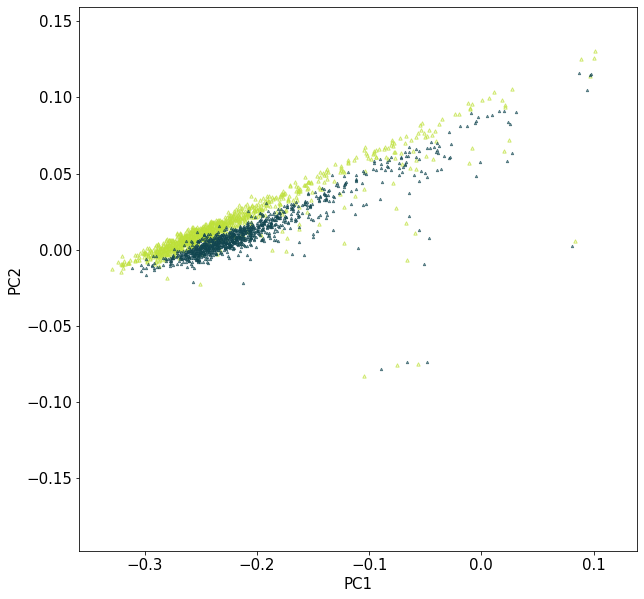

In [66]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 15})

plt.scatter(
    ancestry_preds_tbl.pca_features[0].collect(),
    ancestry_preds_tbl.pca_features[1].collect(),
    color='#ffffff',
    s=2
)

plt.scatter(
    [item[0] for item in a1],
    [item[1] for item in a1],
    marker="^",
    edgecolor="#BDE038BB",
    color="#ffffff11",
    s=10
)

plt.scatter(
    testing_ht.scores[0].collect(),
    testing_ht.scores[1].collect(),
    marker="^",
    edgecolor="#10454FBB",
    color="#ffffff11",
    s=5
)

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

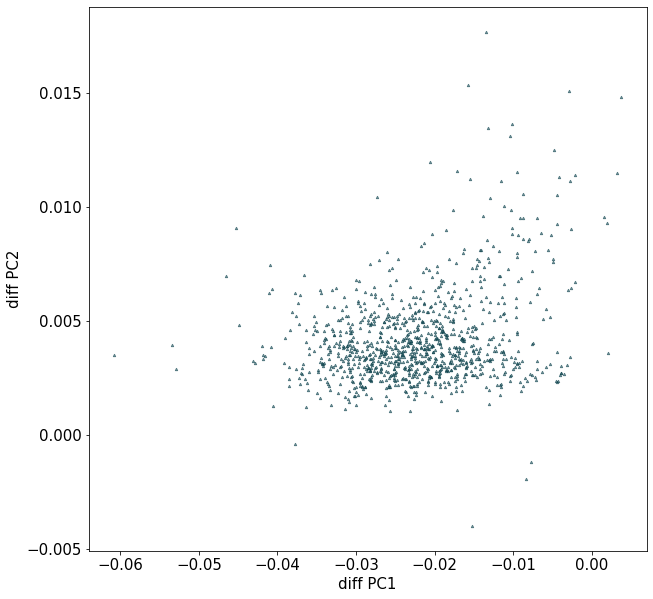

In [68]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 15})

plt.scatter(
    np.subtract([item[0] for item in a1], testing_ht.scores[0].collect()),
    np.subtract([item[1] for item in a1], testing_ht.scores[1].collect()),
    marker="^",
    edgecolor="#10454FBB",
    color="#ffffff11",
    s=5
)

plt.xlabel("diff PC1")
plt.ylabel("diff PC2")

plt.show()

In [71]:
len(testing_ht.scores[0].collect())

1027

In [143]:
len(testing_ht.scores[1].collect())

1027

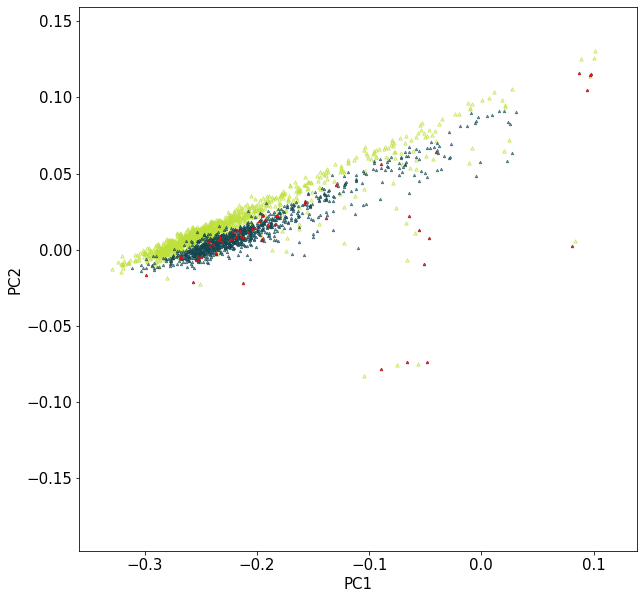

In [79]:
random.seed(15)

b1 = testing_ht.scores[0].collect()
b2 = testing_ht.scores[1].collect()

vi0 = list(filter(lambda i: b1[i] > -0.1 and b2[i] < 0.03, range(len(b2))))
vi1 = list(filter(lambda i: b2[i] < -0.02, range(len(b2)))) + list(filter(lambda i: b1[i] > 0.08, range(len(b1))))
vi2 = random.sample(range(0, 1027), 55 - len(set(vi0+vi1)) + 1)
vi = list(set(vi0+vi1+vi2))

c1 = [b1[index] for index in vi]
c2 = [b2[index] for index in vi]

s_all = list(testing_ht.s.collect())
s = [s_all[index] for index in range(len(vi))]

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 15})

plt.scatter(
    ancestry_preds_tbl.pca_features[0].collect(),
    ancestry_preds_tbl.pca_features[1].collect(),
    color='#ffffff',
    s=2
)

plt.scatter(
    [item[0] for item in a1],
    [item[1] for item in a1],
    marker="^",
    edgecolor="#BDE038BB",
    color="#ffffff11",
    s=10
)

plt.scatter(
    testing_ht.scores[0].collect(),
    testing_ht.scores[1].collect(),
    marker="^",
    edgecolor="#10454FBB",
    color="#ffffff11",
    s=5
)

plt.scatter(
    c1,
    c2,
    marker="^",
    edgecolor="#FF0000BB",
    color="#ffffff11",
    s=5
)


plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

In [80]:
s

['1000151',
 '1000513',
 '1000920',
 '1001399',
 '1001980',
 '1002322',
 '1002826',
 '1004266',
 '1005038',
 '1005444',
 '1005938',
 '1007198',
 '1008775',
 '1010384',
 '1012440',
 '1012736',
 '1013536',
 '1014457',
 '1014625',
 '1014694',
 '1014764',
 '1014823',
 '1015059',
 '1015507',
 '1016971',
 '1016985',
 '1019345',
 '1024761',
 '1025136',
 '1025342',
 '1025566',
 '1025694',
 '1026351',
 '1026529',
 '1026622',
 '1027488',
 '1027673',
 '1029520',
 '1029873',
 '1032052',
 '1032684',
 '1036042',
 '1037292',
 '1037774',
 '1037790',
 '1037792',
 '1037950',
 '1041753',
 '1042609',
 '1044452',
 '1044533',
 '1045706',
 '1046956',
 '1048940',
 '1049766']

2023-03-28 02:20:00.051 Hail: INFO: wrote matrix with 1027 rows and 1027 columns as 1 block of size 4096 to /tmp/pcrelate-write-read-e7z9PEUA6YeMLjKN9jVgnB.bm
2023-03-28 02:36:50.476 Hail: INFO: wrote matrix with 1027 rows and 1027 columns as 1 block of size 4096 to /tmp/pcrelate-write-read-4hWvDWQE2dwYFe9JLiMfVm.bm
2023-03-28 02:36:50.954 Hail: INFO: wrote matrix with 1027 rows and 1027 columns as 1 block of size 4096 to /tmp/pcrelate-write-read-yVCh3XOY7i3luk5qr9zRup.bm


In [172]:
print(len(vi))

print(len(c1))
print(len(c2))

print(len(s))

50
50
50
50


In [173]:
len(set(vi0+vi1))

14

In [134]:
list(filter(lambda i: b2[i] < -0.02, range(len(b2))))

[286, 498, 790, 846, 972]

In [135]:
list(filter(lambda i: b1[i] > 0.08, range(len(b1))))

[314, 336, 428, 744, 991]

In [139]:
s

['1000151',
 '1000513',
 '1000920',
 '1001399',
 '1001980',
 '1002322',
 '1002826',
 '1004266',
 '1005038',
 '1005444',
 '1005938',
 '1007198',
 '1008775',
 '1010384',
 '1012440',
 '1012736',
 '1013536',
 '1014457',
 '1014625',
 '1014694',
 '1014764',
 '1014823',
 '1015059',
 '1015507',
 '1016971',
 '1016985',
 '1019345',
 '1024761',
 '1025136',
 '1025342',
 '1025566',
 '1025694',
 '1026351',
 '1026529',
 '1026622',
 '1027488',
 '1027673',
 '1029520',
 '1029873',
 '1032052',
 '1316872',
 '1577460',
 '1909666',
 '1964615',
 '2633780',
 '1353030',
 '1375011',
 '1485021',
 '1867496',
 '2966274']

In [153]:
vi

[768,
 641,
 4,
 902,
 909,
 782,
 277,
 790,
 23,
 409,
 153,
 286,
 293,
 551,
 39,
 298,
 428,
 172,
 943,
 431,
 562,
 691,
 179,
 821,
 696,
 314,
 187,
 829,
 458,
 972,
 717,
 846,
 333,
 336,
 335,
 467,
 858,
 989,
 991,
 351,
 867,
 868,
 231,
 744,
 106,
 753,
 498,
 121,
 125]

In [152]:
vi2

[972,
 551,
 717,
 293,
 782,
 23,
 768,
 989,
 562,
 943,
 467,
 4,
 298,
 902,
 753,
 333,
 696,
 431,
 121,
 409,
 153,
 691,
 829,
 179,
 39,
 125,
 458,
 187,
 868,
 909,
 231,
 867,
 277,
 641,
 335,
 106,
 351,
 172,
 821,
 858]

In [142]:
c1

[-0.23279814564919232,
 -0.17478748860250617,
 -0.22513530200792134,
 -0.23152472015972053,
 -0.06480866336861564,
 -0.23233090666982528,
 -0.22396381308418897,
 -0.24020012195364263,
 -0.19026093398196492,
 -0.1577419578283572,
 -0.05967917928354662,
 -0.25124091491635353,
 -0.19660807261008947,
 -0.26361386059327163,
 -0.13871993102845795,
 -0.1551442191926845,
 -0.2598577370667077,
 -0.29149013550408087,
 -0.2344303436891333,
 -0.2531123735960981,
 -0.2220522891929951,
 -0.1063049094351825,
 -0.23638488482581324,
 -0.21785478575051903,
 -0.1533132567695145,
 -0.25188237704326083,
 -0.18915442240048608,
 -0.281166847017452,
 -0.1475112319728117,
 -0.1568200058403302,
 -0.24474913954756558,
 -0.24755374957532572,
 -0.23350432035597185,
 -0.2696251213656652,
 -0.2020393763982875,
 -0.23789128542925822,
 -0.2928111206012143,
 -0.2527982307547351,
 -0.040101852307446395,
 -0.23493204439533938]

In [144]:
list(filter(lambda i: b1[i] > 0.08, range(len(b1))))

[314, 336, 428, 744, 991]

In [175]:
len(s)

50

In [176]:
s

['1000151',
 '1000513',
 '1000920',
 '1001399',
 '1001980',
 '1002322',
 '1002826',
 '1004266',
 '1005038',
 '1005444',
 '1005938',
 '1007198',
 '1008775',
 '1010384',
 '1012440',
 '1012736',
 '1013536',
 '1014457',
 '1014625',
 '1014694',
 '1014764',
 '1014823',
 '1015059',
 '1015507',
 '1016971',
 '1016985',
 '1019345',
 '1024761',
 '1025136',
 '1025342',
 '1025566',
 '1025694',
 '1026351',
 '1026529',
 '1026622',
 '1027488',
 '1027673',
 '1029520',
 '1029873',
 '1032052',
 '1032684',
 '1036042',
 '1037292',
 '1037774',
 '1037790',
 '1037792',
 '1037950',
 '1041753',
 '1042609',
 '1044452']